This is the final code for the polynomial approximations

In [156]:
import torch
from mpmath import mp
import numpy as np
import math
from scipy import optimize as opt
import matplotlib.pyplot as plt
from matplotlib import cm # for 3d poltting
from mpl_toolkits.mplot3d.axes3d import Axes3D # for 3d poltting
from sympy import symbols, cos, pi
from sympy.core.numbers import One
from sympy.utilities.lambdify import lambdify
from math import sin, pi

In [157]:
def remez(func, n_degree:int, lower:float=-1, upper:float=1, max_iter:int = 10):
    """
    :param func: a function (or lambda) f: X -> R
    :param n_degree: the degree of the polynomial to approximate the function f
    :param lower: lower range of the approximation
    :param upper: upper range of the approximation
    :return: the polynomial coefficients, and an approximate maximum error associated with this approximation
    """
    def bisection_search(f, low:float, high:float):
        """
        A root finding method that does not rely on derivatives
        :param f: a function f: X -> R
        :param low: the lower bracket
        :param high: the upper limit bracket
        :return: the location of the root, e.g. f(mid) ~ 0
        """
        # flip high and low if out of order
        if f(high) < f(low):
            low, high = high, low

        # find mid point
        mid = .5 * (low + high)

        while True:
            # bracket up
            if f(mid) < 0:
                low = mid
            # braket down
            else:
                high = mid

            # update mid point
            mid = .5 * (high + low)

            # break if condition met
            if abs(high - low) < 10 ** (-(mp.dps / 2)):
                break

        return mid

    def chev_points(n:int, lower:float = -1, upper:float = 1):
        """
        Generates a set of chebychev points spaced in the range [lower, upper]
        :param n: number of points
        :param lower: lower limit
        :param upper: upper limit
        :return: a list of multipressison chebychev points that are in the range [lower, upper]
        """
        index = np.arange(1, n+1)
        range_ = abs(upper - lower)
        return [(.5*(mp.cos((2*i-1)/(2*n)*mp.pi)+1))*range_ + lower for i in index]

    def concave_max(f, low:float, high:float):
        """
        Forms a lambda for the approximate derivative and finds the root
        :param f: a function f: X -> R
        :param low: the lower bracket
        :param high: the upper limit bracket
        :return: the location of the root f'(mid) ~ 0
        """
        # create an approximate derivative expression
        scale = high - low

        h = mp.mpf('0.' + ''.join(['0' for i in range(int(mp.dps / 1.5))]) + '1') * scale
        df = lambda x: (f(x + h) - f(x - h)) / (2.0 * h)

        return bisection_search(df, low, high)

    # initialize the node points
    x_points = chev_points(n_degree + 2, lower, upper)

    A = mp.matrix(n_degree + 2)
    coeffs = np.zeros(n_degree + 2)

    # place in the E column
    mean_error = float('inf')

    for i in range(n_degree + 2):
        A[i, n_degree + 1] = (-1) ** (i + 1)

    for i in range(max_iter):

        # build the system
        vander = np.polynomial.chebyshev.chebvander(x_points, n_degree)

        for i in range(n_degree + 2):
            for j in range(n_degree + 1):
                A[i, j] = vander[i, j]

        b = mp.matrix([func(x) for x in x_points])
        l = mp.lu_solve(A, b)

        coeffs = l[:-1]

        # build the residual expression
        r_i = lambda x: (func(x) - np.polynomial.chebyshev.chebval(x, coeffs))

        interval_list = list(zip(x_points, x_points[1:]))
        #         interval_list = [[x_points[i], x_points[i+1]] for i in range(len(x_points)-1)]

        intervals = [upper]
        intervals.extend([bisection_search(r_i, *i) for i in interval_list])
        intervals.append(lower)

        extermum_interval = [[intervals[i], intervals[i + 1]] for i in range(len(intervals) - 1)]

        extremums = [concave_max(r_i, *i) for i in extermum_interval]

        extremums[0] = mp.mpf(upper)
        extremums[-1] = mp.mpf(lower)

        errors = [abs(r_i(i)) for i in extremums]
        mean_error = np.mean(errors)

        x_points = extremums

    return [float(i) for i in np.polynomial.chebyshev.cheb2poly(coeffs)], float(mean_error)

    

In [188]:
class HatMinMaxApproximator:
    def __init__(self, a,b,c,deg,left,right):
        def bump(x):
            return BasicSigmoids.square(x,a,b,c)
        self.poly_coeffs, self.max_error = remez(bump, deg, left, right, 10)
        self.evaluator = lambda x : np.polyval(self.poly_coeffs[::-1], x)
    
    def get_max_error():
        return self.max_error
    
    def get_poly_coeffs():
        return self.poly_coeffs
    
    def __call__(x):
        return self.evaluator(x)

In [202]:
# CHEBYSHEV HELPER FUNCTIONS
# might be incoherent with Emin's minimax helper fnuctions

class BasicSigmoids:
    @staticmethod
    def sigmoid(x, a, c):
        exponent = (-(x-a))/c
        denom = 1 + (math.e**(exponent))
        return 1/denom
    @staticmethod
    def square(x,a,b,c):
        s1=BasicSigmoids.sigmoid(x, a, c)
        s2=BasicSigmoids.sigmoid(x, b, -c)
        return s1*s2
    @staticmethod
    def scale_up(z,x_min,x_max):
        """
        Scales up z \in [-1,1] to x \in [x_min,x_max]
        where z = (2 * (x - x_min) / (x_max - x_min)) - 1
        """

        return x_min + (z + 1) * (x_max - x_min) / 2
    @staticmethod
    def scale_down(x,x_min,x_max):
        """
        Scales down x \in [x_min,x_max] to z \in [-1,1]
        where z = f(x) = (2 * (x - x_min) / (x_max - x_min)) - 1
        """    

        return (2 * (x - x_min) / (x_max - x_min)) - 1

class ChebyshevApproximator:
    def __init__(self, function, intr, deg, prec = 15):
        n = deg + 1

        x, u = symbols('x u')

        a, b = intr
        x_to_u = (2 * x - a - b) / (b - a)
        u_to_x = (b - a) / 2 * u + (a + b) / 2
        chebyshev_nodes = cos((symbols('i') + 0.5) / n * pi)

        result_u = [chebyshev_nodes.evalf(prec, subs={'i': i}) for i in range(n)]
        result_x = [u_to_x.evalf(prec, subs={u: i}) for i in result_u]
        result_y = [function(i) for i in result_x]

        t = [One(), u]

        for _ in range(n - 2):
            t.append(2 * u * t[-1] - t[-2])

        c = [sum(result_y) / n]

        for index in range(1, n):
            c.append(2 * sum(t[index].evalf(prec, subs={u: i}) * j for i, j in zip(result_u, result_y)) / n)

        y = 1 * c[0]

        for i in range(1, n):
            y += t[i] * c[i]

        y = y.subs({u: x_to_u}).simplify()

        self.y = y        
        x, u = symbols('x u')    
        self.f = lambdify(x, self.y, "numpy")
        f.formula = y
    
    def _get_y(self):
        return self.y
    
    def __call__(self, x):
        return self.f(x)
    
    def get_coeffs(self):
        def cheby_to_coeff_list(s): 
            s_coeffs =  [((t.args[1].args[1] if (len(t.args[1].args) != 0)else 1), t.args[0]) for t in s.args[1:]] + [(0, s.args[0])]
            return [x[1] for x in sorted(s_coeffs)]

        return cheby_to_coeff_list(self.y)

class HatChebyshevApproximator(ChebyshevApproximator):
    def __init__(self,a,b,c,deg,left,right):
        def hat(x):
            return BasicSigmoids.square(x,a,b,c)
        
        super().__init__(hat, (left,right),deg)


In [194]:
#MINMAX FUNCTIONS ^^^ make sure you run helper functions above
#For minmax_polynomials, the function returns an array of the cofficients
#Notice: these are ordered from the LOWEST degree (i.e., x^0) to the HIGHEST degree (i.e., x^{deg})

# def minmax_polynomials(a,b,c,deg,left,right):
#   #INPUTS:
#   #a: left sigmoid cutoff; b: right sigmoid cutoff; c: steepnesss parameter; deg: degree of approximating polynomial; (left,right): range of the approximation
#   #OUTPUTS:
#   #poly_coeffs: a list of coefficents for the minimax polynomial of degree deg for the sq bump with the parameters a,b,c
  
#   def bump(x):
#     return BasicSigmoids.square(x,a,b,c)
#   poly_coeffs, max_error = remez(bump, deg, left, right, 10)

#   return poly_coeffs

# def minmax_function(a,b,c,deg,left,right):
#   #INPUTS:
#   #a: left sigmoid cutoff; b: right sigmoid cutoff; c: steepnesss parameter; deg: degree of approximating polynomial; (left,right): range of the approximation
#   #OUTPUTS:
#   #minmax_approximation: the minmax approximation, as a function. DONT USE IT OUTSIDE [left, right]
  
#   poly_coeffs=minmax_polynomials(a,b,c,deg,left,right)

#   def minmax_approximation(x):
#     y_approx = np.polyval(poly_coeffs[::-1], x)
#     return y_approx
  
#   return minmax_approximation

In [195]:
g = minmax_function(-1,1,0.005,3,-2,2)
torch.Tensor(g(torch.Tensor([-2, .5, 0, 1, 2])))

tensor([-0.4781,  0.7449,  0.8264,  0.5003, -0.4781])

In [216]:
example = HatChebyshevApproximator(-1,1,0.005,10,-2,2)

In [217]:
example(torch.Tensor([-2,-1,0,1, 2]))

tensor([0.0986, 0.1647, 1.0000, 0.1647, 0.0986])

In [218]:
example.get_coeffs()

[1.00000000000000,
 2.34499751567888e-16,
 1.04418460978309,
 -8.71591608768755e-17,
 -4.18369718533247,
 -1.22285398222244e-16,
 3.08426407359995,
 6.84136323366963e-17,
 -0.863598136334388,
 -9.01616520405319e-18,
 0.0835441636999943]

In [166]:
h = cheby_function(-1,1,0.005,5,-2,2)
print(h)

<class 'sympy.core.add.Add'>
<function _lambdifygenerated at 0x7f95f869bc10>


<class 'sympy.core.add.Add'>


/var/folders/mk/ydf2207j325_0l9ph1swkbzc0000gq/T/ipykernel_16126/2710122744.py:8: RuntimeWarning: overflow encountered in power
  denom = 1 + (math.e**(exponent))


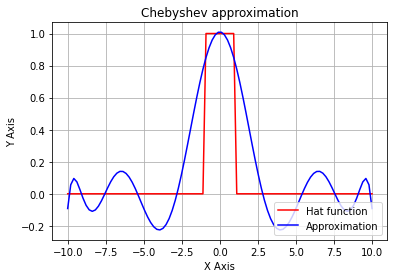

In [211]:
#PLOTING (to make sure things look correct)
a = -1
b = 1
c = 0.005
left = -10
right = 10
deg = 10

def hat(x): #need to call the function like this otherwise there is an error
    return BasicSigmoids.square(x,a,b,c)
  
f = cheby_function(a,b,c,deg,left,right)
x = np.linspace(left, right, 100)
z = BasicSigmoids.square(x,a,b,c)
y = f(x)*1.01

plt.plot(x, z, 'r', label='Hat function')
plt.plot(x, y, 'b', label='Approximation')

plt.grid()

plt.title('Chebyshev approximation')

plt.legend(loc='lower right')

# plt.plot(x)
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# create the graph
plt.savefig("f1.png")
plt.show()